In [94]:
# Reference: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

## for data
import json
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import re

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection, metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lin_menghsien/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lin_menghsien/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df_merge_quality = pd.read_csv('US_patent_abstract_5000_2015_with_title_1.csv')
df_merge_quality.shape

(5000, 30)

In [8]:
df = df_merge_quality[['claims_text', 'quality_rank']]
df

,claims_text,quality_rank
0,1. A device comprising:\n memory to store inst...,0
1,The invention claimed is: \n \n 1. A...,1
2,What is claimed is: \n \n 1. An imag...,0
3,The invention claimed is: \n \n 1. A...,1
4,What is claimed is: \n \n 1. A compu...,0
...,...,...
4995,The invention claimed is: \n \n 1. A...,1
4996,What is claimed is: \n \n 1. A metho...,1
4997,What is claimed is: \n \n 1. A solid...,0
4998,The invention claimed is: \n \n 1. A...,1


In [10]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [13]:
# stopwords candidate
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [19]:
df["text_clean"] = df["claims_text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
df.head()

/home/lin_menghsien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,claims_text,quality_rank,text_clean
0,1. A device comprising:\n memory to store inst...,0,1 device comprising memory store instruction d...
1,The invention claimed is: \n \n 1. A...,1,invention claimed 1 control system elevator co...
2,What is claimed is: \n \n 1. An imag...,0,claimed 1 image forming apparatus comprising i...
3,The invention claimed is: \n \n 1. A...,1,invention claimed 1 switching power supply dev...
4,What is claimed is: \n \n 1. A compu...,0,claimed 1 computer system including instructio...


In [37]:
x_train_raw = df['text_clean'][:4000].values
x_dev_raw = df['text_clean'][4000:].values

y_train = df['quality_rank'][:4000].values
y_dev = df['quality_rank'][4000:].values

In [100]:
1 - sum(y_train) / len(y_train) # majority class in train set = 0.58

0.5800000000000001

In [99]:
1 - sum(y_dev) / len(y_dev) # majority class in dev set = 0.576

0.5760000000000001

In [84]:
x_train_raw[:2]

array(['1 device comprising memory store instruction device first device processor execute instruction receive first message second message second device first message second message differ first message includes first header first event data second message includes second header second event data identify based first header second header first message second message problem report process response identifying first message second message problem report first event data determine first event data first message associated particular reconfiguration information plurality reconfiguration information corresponding second device process response identifying first message second message problem report second event data determine second event data second message associated plurality reconfiguration information transmit particular reconfiguration information second device response first message determine additional information based processing second event data form based processing second eve

In [38]:
y_dev.shape
x_dev_raw.shape

(1000,)

In [40]:
## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [41]:
vectorizer.fit(x_train_raw)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=10000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [42]:
X_train = vectorizer.transform(x_train_raw)

In [43]:
X_train

<4000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 523634 stored elements in Compressed Sparse Row format>

In [45]:
# vocabulary dictinoary
dic_vocabulary = vectorizer.vocabulary_

Text(0.5, 1, 'Sparse Matrix Sample')

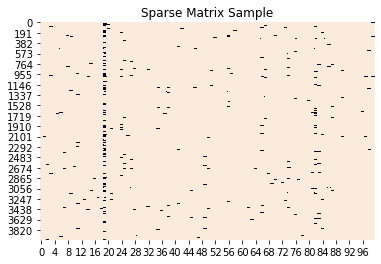

In [44]:
# to visualize its sparsity
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [77]:
# check on some examples

dic_vocabulary['device'] # this command prints a number N, meaning that the Nth feature of the matrix is that word
dic_vocabulary['device comprising']


2535

In [78]:
X_names = vectorizer.get_feature_names()
len(X_names)

10000

In [79]:
# to further reduce the matrix dimensionality. Original we have 10000 vocabulary here since we specify it above (contain both unigram and bigram)
# Experiment: if I set p_value to be 0.95, there would only be left with 1 vocabulary "vehicle"... 
# This is not a good sign, almost signal that claim's unigram and bigram is not a good predictor to quality score.

y = y_train
X_names = vectorizer.get_feature_names()
p_value_limit = 0.3
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [80]:
dtf_features

,feature,score,y
9536,vehicle,0.991457,0
6784,program chain,0.949095,0
1087,cache,0.945682,0
3093,energy,0.939302,0
3844,game,0.917651,0
...,...,...,...
9674,wash,0.300480,1
6681,pressure sensor,0.300426,1
8411,sourcedestination,0.300416,1
8412,sourcedestination pair,0.300416,1


In [81]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# 0:
  . selected features: 4356
  . top features: vehicle,program chain,cache,energy,game,resonant,moiety,trench,polymer,belt
 
# 1:
  . selected features: 4356
  . top features: vehicle,program chain,cache,energy,game,resonant,moiety,trench,polymer,belt
 


In [66]:
# for the time-being, perhaps let's keep entire 10K vocabulary and se the result

4356

In [82]:
# try Naive Bayes classifier

classifier = naive_bayes.MultinomialNB()

In [86]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model.fit(x_train_raw, y_train)


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=10000,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [88]:
## test

predicted = model.predict(x_dev_raw)
predicted_prob = model.predict_proba(x_dev_raw)


In [90]:
print(len(predicted))
predicted

1000


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
## test

predicted = model.predict(x_dev_raw)
predicted_prob = model.predict_proba(x_dev_raw)


In [92]:
print(predicted_prob.shape)
predicted_prob

(1000, 2)


array([[0.53099144, 0.46900856],
       [0.76161554, 0.23838446],
       [0.64757122, 0.35242878],
       ...,
       [0.79780612, 0.20219388],
       [0.85177186, 0.14822814],
       [0.70894875, 0.29105125]])

In [96]:
accuracy = metrics.accuracy_score(y_test, predicted)
accuracy

0.598

Accuracy: 0.598
Auc: 0.549
Detail:
              precision    recall  f1-score   support

           0       0.60      0.87      0.71       576
           1       0.56      0.23      0.32       424

    accuracy                           0.60      1000
   macro avg       0.58      0.55      0.52      1000
weighted avg       0.59      0.60      0.55      1000



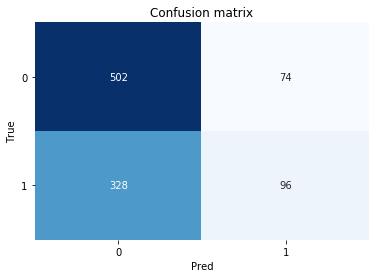

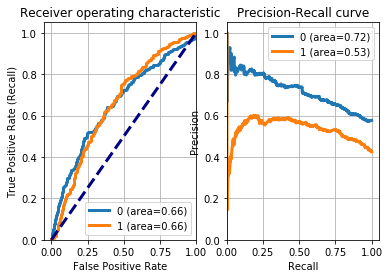

In [103]:
y_test = y_dev

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted)  # predicted_prob), check doc, seems the second argument required to be shape (n_samples,) for binary case 
                            #multi_class="ovr") # check documentation and seems "ovr" not good for only binary target class
print("Accuracy:",  round(accuracy,3))
print("Auc:", round(auc,3))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

### Below just for comparison purpose, look at the prediction performance on training set

In [104]:
# Take a look on the prediction result on training set

predicted_train = model.predict(x_train_raw)
predicted_prob_train = model.predict_proba(x_train_raw)

Accuracy: 0.754
Auc: 0.716
Detail:
              precision    recall  f1-score   support

           0       0.72      0.95      0.82      2320
           1       0.88      0.48      0.62      1680

    accuracy                           0.75      4000
   macro avg       0.80      0.72      0.72      4000
weighted avg       0.79      0.75      0.73      4000



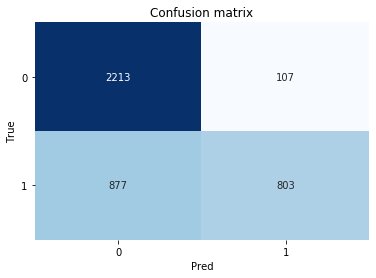

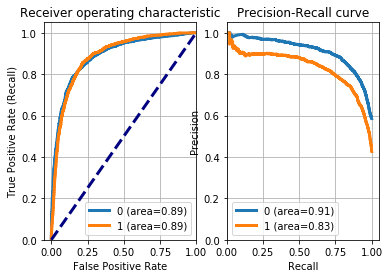

In [106]:

classes = np.unique(y_train)
y_train_array = pd.get_dummies(y_train, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_train, predicted_train)
auc = metrics.roc_auc_score(y_train, predicted_train)  # predicted_prob_train), check doc, seems the second argument required to be shape (n_samples,) for binary case 
                            #multi_class="ovr") # check documentation and seems "ovr" not good for only binary target class
print("Accuracy:",  round(accuracy,3))
print("Auc:", round(auc,3))
print("Detail:")
print(metrics.classification_report(y_train, predicted_train))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_train, predicted_train)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_train_array[:,i],  
                           predicted_prob_train[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_train_array[:,i], predicted_prob_train[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()